In [38]:
import os

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Data preprocessing

In [3]:
DATA_DIR = "/home/jimena/Bartonella/ge_classifier/features"
ID_MAP = "/home/jimena/Bartonella/ge_classifier/features/locustag2deg_id95.csv"
data_files = [f for f in os.listdir(DATA_DIR) if f.endswith("_feature_table.csv")]

In [4]:
all_genes = pd.DataFrame()
for file in data_files:
    df = pd.read_csv(os.path.join(DATA_DIR, file), index_col=0)
    df["organism"] = file.split("_")[0]
    all_genes = pd.concat([all_genes, df])
all_genes = all_genes[~all_genes.index.duplicated(keep="last")]  # remove duplicates
# all_genes = all_genes[["organism", *df.columns.tolist()[:-1]]]  # reorder columns
locustag2deg = pd.read_csv(ID_MAP, usecols=[1,2], index_col="locus_tag", na_values="-")
locustag2deg = locustag2deg[~locustag2deg.index.duplicated(keep="last")]
all_genes = all_genes.join(locustag2deg, how="inner")
deg_genes = all_genes.dropna(subset=["deg_id"])
deg_genes["essential"] = deg_genes["deg_id"].map(lambda x: "non-essential" if "N" in x else "essential")

/home/jimena/anaconda3/envs/tfm-jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [5]:
deg_genes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91748 entries, SPY49_RS00010 to BTH_RS29200
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   strand_lead  91748 non-null  int64  
 1   geptop       91748 non-null  float64
 2   T3s          91748 non-null  float64
 3   C3s          91748 non-null  float64
 4   A3s          91748 non-null  float64
 5   G3s          91748 non-null  float64
 6   Nc           91500 non-null  float64
 7   GC           91748 non-null  float64
 8   L_sym        91748 non-null  int64  
 9   L_aa         91748 non-null  int64  
 10  Gravy        91748 non-null  float64
 11  Aromo        91748 non-null  float64
 12  deltaGC      91748 non-null  float64
 13  organism     91748 non-null  object 
 14  deg_id       91748 non-null  object 
 15  essential    91748 non-null  object 
dtypes: float64(10), int64(3), object(3)
memory usage: 11.9+ MB


In [6]:
deg_genes["essential"].value_counts()

non-essential    79906
essential        11842
Name: essential, dtype: int64

# Exploratory data analysis

In [16]:
# pd.plotting.scatter_matrix(deg_genes.iloc[:,:-1], figsize = [8, 8],
# s=150, marker = 'D')

# Classifier training

In [7]:
FEATURES = ["strand_lead", "geptop", "T3s", "C3s", "A3s", "G3s",
            "Nc", "GC", "L_sym", "L_aa", "Gravy", "Aromo", "deltaGC"]
X = deg_genes[FEATURES].values  # feature array
y = deg_genes["essential"].values  # target array

## No undersampling, default hyperparameters

In [8]:
pipeline = Pipeline([
    ("imputation", SimpleImputer(missing_values=np.nan, strategy='mean')),  # impute missing data (Nc values)
    ("scaling", MinMaxScaler()),  # scale data to [0, 1]
    ("logistic_regression", LogisticRegression(solver="saga"))
])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [10]:
pipeline.fit(X_train, y_train)
y_pred_prob = pipeline.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.8457449015204281

In [30]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="roc_auc", n_jobs=-1)
print(cv_scores.mean(), cv_scores.var())

0.7866642756378118 0.006906998295357046


## Undersampling of non-essential genes

In [13]:
from imblearn.under_sampling import RandomUnderSampler

In [59]:
rus = RandomUnderSampler(sampling_strategy=1, random_state=123)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [75]:
pipeline = Pipeline([
    ("imputation", SimpleImputer(missing_values=np.nan, strategy='mean')),  # impute missing data (Nc values)
    ("scaling", MinMaxScaler()),  # scale data to [0, 1]
    ("logistic_regression", LogisticRegression())
])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=123)

In [76]:
pipeline.fit(X_train, y_train)
y_pred_prob = pipeline.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.84893987716292

In [31]:
cv_scores = cross_val_score(pipeline, X_resampled, y_resampled, cv=5, scoring="roc_auc", n_jobs=-1)
print(cv_scores.mean(), cv_scores.var())

0.79503317468354 0.004137859897743528


-> Higher avg AUC, lower variance with undersampling. Also much faster.

## Hyperparameter tuning

In [99]:
params = {
    "logistic_regression__C": np.logspace(-2, 2),
    "logistic_regression__penalty": ["l1", "l2"]
}
pipeline = Pipeline([
    ("imputation", SimpleImputer(missing_values=np.nan, strategy='mean')),  # impute missing data (Nc values)
    ("scaling", MinMaxScaler()),  # scale data to [0, 1]
    ("logistic_regression", LogisticRegression(solver="saga"))
])
search = GridSearchCV(pipeline, params, scoring="roc_auc", n_jobs=-1)

In [100]:
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('imputation', SimpleImputer()),
                                       ('scaling', MinMaxScaler()),
                                       ('logistic_regression',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic_regression__C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                         'logistic_regression__penalty': ['l1', 'l2']},
   

In [101]:
search.best_params_

{'logistic_regression__C': 0.017575106248547922,
 'logistic_regression__penalty': 'l1'}

In [103]:
y_pred_prob = search.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.8537808584031038

In [102]:
cv_scores = cross_val_score(search, X_resampled, y_resampled, cv=5, scoring="roc_auc", n_jobs=-1)
print(cv_scores.mean(), cv_scores.var())

0.8046714173440425 0.0034147941611028187


In [108]:
search.best_estimator_.named_steps["logistic_regression"].coef_

array([[ 0.00000000e+00, -6.08922719e+00, -1.66278115e-03,
         0.00000000e+00, -1.17175813e-01,  0.00000000e+00,
         0.00000000e+00,  6.05820377e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

## Feature selection

In [69]:
import matplotlib.pyplot as plt

**L2 regularization**

In [88]:
pipeline_l2 = Pipeline([
    ("imputation", SimpleImputer(missing_values=np.nan, strategy='mean')),  # impute missing data (Nc values)
    ("scaling", MinMaxScaler()),  # scale data to [0, 1]
    ("logistic_regression", LogisticRegression(solver="saga"))
])

In [89]:
pipeline_l2.fit(X_train, y_train)
y_pred_prob = pipeline_l2.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.8489387629822658

In [90]:
pipeline_l2.named_steps["logistic_regression"].coef_

array([[ 0.03431828, -6.91842011, -0.43408867, -0.73423416, -0.55522059,
         0.27560508,  0.79285617,  1.15011676, -0.34667606, -0.08179699,
        -0.27869298,  0.55369881,  0.39674999]])

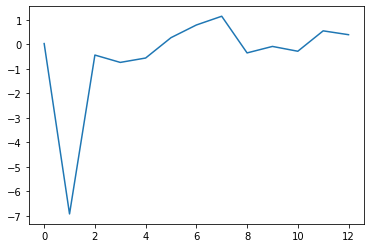

In [91]:
plt.plot(pipeline_l2.named_steps["logistic_regression"].coef_.flatten())

**L1 regularization**

In [109]:
pipeline_l1 = Pipeline([
    ("imputation", SimpleImputer(missing_values=np.nan, strategy='mean')),  # impute missing data (Nc values)
    ("scaling", MinMaxScaler()),  # scale data to [0, 1]
    ("logistic_regression", LogisticRegression(C=0.0176, penalty="l1", solver="saga"))
])

In [110]:
pipeline_l1.fit(X_train, y_train)
y_pred_prob = pipeline_l1.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.8537797887896758

In [111]:
pipeline_l1.named_steps["logistic_regression"].coef_

array([[ 0.00000000e+00, -6.09060361e+00, -8.53967444e-04,
         0.00000000e+00, -1.17791237e-01,  0.00000000e+00,
         0.00000000e+00,  6.06529645e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

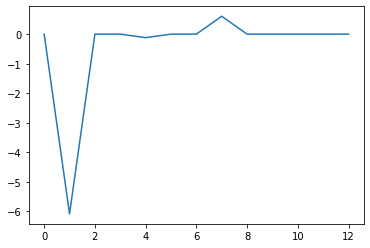

In [112]:
plt.plot(pipeline_l1.named_steps["logistic_regression"].coef_.flatten())

In [ ]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

roc_auc_score(y_test, y_pred_prob)

cv_scores = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')